## Problem -- lowpass filtering of a 2-d image
For the image above, 
we know that the 25 meter pixels correspond to k=1/0.025 = 40 $km^{-1}$.  That means that the Nyquist
wavenumber is k=20 $km^{-1}$.  Using that information, design a filter that removes all wavenumbers
higher than 1 $km^{-1}$.   

1) Use that filter to zero those values in the fft, then inverse transform and
plot the low-pass filtered image.

2) Take the 1-d fft of the image and repeat the plot of the power spectrum to show that there is no power in wavenumbers higher than 1 $km^{-1}$.

(Hint -- I used the fftshift function to put the low wavenumber cells in the center of the fft, which made it simpler to zero the outer cells.  I then used ifftshift to reverse shift before inverse transforming to get the filtered
image.)



In [37]:
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt
from netCDF4 import Dataset

class gw_fft:

    def __init__(self, filename, var, scale):
        """
           Input filename, var=variable name,
           scale= the size of the pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        with Dataset(filename, 'r') as fin:
            data = fin.variables[var][...]
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError('expecting square matrix')
        self.xdim = data.shape[0]  # size of each row of the array
        self.midpoint = int(math.floor(self.xdim / 2))
        root, suffix = filename.split('.')
        self.filename = root
        self.var = var
        self.scale = float(scale)
        self.data = data
        self.fft_data = fft.fft2(self.data)

    def power_spectrum(self):
        """
           calculate the power spectrum for the 2-dimensional field
        """
        #
        # fft_shift moves the zero frequency point to the  middle
        # of the array
        #
        fft_shift = fft.fftshift(self.fft_data)
        spectral_dens = fft_shift * np.conjugate(fft_shift) / (self.xdim * self.xdim)
        spectral_dens = spectral_dens.real
        #
        #
        # dimensional wavenumbers for 2dim spectrum  (need only the kx
        # dimensional since image is square
        #
        k_vals = np.arange(0, (self.midpoint)) + 1
        k_vals = (k_vals - self.midpoint) / (self.xdim * self.scale)
        self.spectral_dens = spectral_dens
        self.k_vals = k_vals
        
    ### g.w.
    def filter_spectrum(self):
        nyquist = 20
        max_k = 1
        one_hz_index = int(max_k / nyquist * len(self.k_vals))
        #
        filter_func = np.zeros_like(self.fft_data)
        #
        filter_func[0:one_hz_index,0:one_hz_index]=1
        filter_func[-one_hz_index:0,0:one_hz_index]=1
        filter_func[0:one_hz_index,-one_hz_index:0]=1
        filter_func[-one_hz_index:0, -one_hz_index:0]=1
        #
        filtered_fft=np.real(np.fft.ifft2(filter_func*self.fft_data))
        shift_filtFFT = fft.fftshift(filter_func*self.fft_data)
        #
        filtered_spec_dens = shift_filtFFT * np.conjugate(shift_filtFFT) / (self.xdim * self.xdim)
        filtered_spec_dens = filtered_spec_dens.real
        #
        self.filtered_image = filtered_fft
        self.filtered_spec_dens = filtered_spec_dens
    ###

    def annular_avg(self,avg_binwidth):
        """
         integrate the 2-d power spectrum around a series of rings
         of radius kradial and average into a set of 1-dimensional
         radial bins
        """
        #
        #  define the k axis which is the radius in the 2-d polar version of E
        #
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)

        avg_spec = np.zeros(numbins,np.float64)
        ### g.w.
        avg_filt_spec = np.zeros(numbins,np.float64)
        ###
        bin_count = np.zeros(numbins,np.float64)

        print("\t- INTEGRATING... ")
        for i in range(self.xdim):
            if (i%100) == 0:
                print("\t\trow: {} completed".format(i))
            for j in range(self.xdim):
                kradial = math.sqrt(((i+1)-self.xdim/2)**2+((j+1)-self.xdim/2)**2)
                bin_num = int(math.floor(kradial/avg_binwidth))
                avg_spec[bin_num]=avg_spec[bin_num]+ kradial*self.spectral_dens[i,j]
                ### g.w.
                avg_filt_spec[bin_num]=avg_filt_spec[bin_num]+ kradial*self.filtered_spec_dens[i,j]
                ###
                bin_count[bin_num]+=1

        for i in range(numbins):
            if bin_count[i]>0:
                avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
                ### g.w.
                avg_filt_spec[i]=avg_filt_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
                ###
        self.avg_spec=avg_spec
        ### g.w.
        self.avg_filt_spec=avg_filt_spec
        ###
        #
        # dimensional wavenumbers for 1-d average spectrum
        #
        self.k_bins=np.arange(numbins)+1
        self.k_bins = self.k_bins[0:self.midpoint]
        self.avg_spec = self.avg_spec[0:self.midpoint]
        ### g.w.
        self.avg_filt_spec = self.avg_filt_spec[0:self.midpoint]
        ###



    # def graph_spectrum(self, kol_slope=-5./3., kol_offset=1., \
    #                   title=None):
    def graph_spectrum(self, kol_slope=-5./3., kol_offset=1.):
        """
           graph the annular average and compare it to Kolmogorov -5/3
        """
        avg_spec=self.avg_spec
        ### g.w.
        avg_filt_spec=self.avg_filt_spec
        ###
        delta_k = 1./self.scale                # 1./km (1/0.025 for landsat 25 meter pixels)
        nyquist = delta_k * 0.5
        knum = self.k_bins * (nyquist/float(len(self.k_bins)))# k = w/(25m)
        #
        # draw the -5/3 line through a give spot
        #
        kol = kol_offset*(knum**kol_slope)
        fig,[ax,ax2]=plt.subplots(1,2,figsize=(15,8))
        ax.loglog(knum,avg_spec,'r-',label='power')
        ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ### g.w.
        # ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
        ax.set(title='Landsat {} power spectrum'.format(self.filename),xlabel='k (1/km)',ylabel='$E_k$')
        ###
        ax.legend()
        self.plotax=ax
        #
        ### gw.w
        ax2.loglog(knum,avg_filt_spec,'r-',label='power')
        ax2.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ax2.set(title='Landsat {} filtered power spectrum'.format(self.filename),xlabel='k (1/km)',ylabel='$E_k$')
        ax2.legend()
        self.plotax=ax2
        ###

In [38]:
plt.close('all')
plt.style.use('ggplot')
output = gw_fft('a17.nc','tau',0.025)
output.power_spectrum()
output.filter_spectrum()

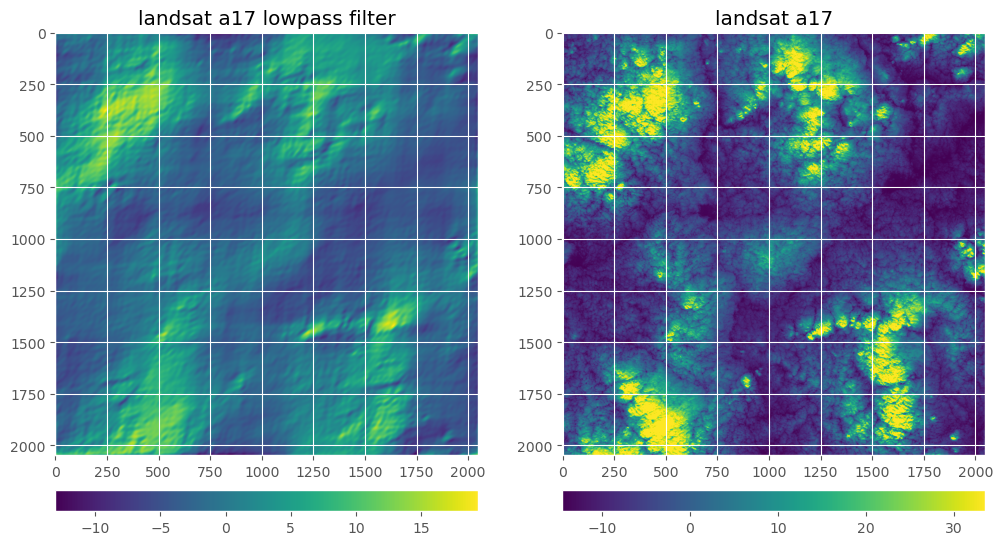

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,[ax1, ax2]=plt.subplots(1,2,figsize=(12,7))
ax1.set_title('landsat a17 lowpass filter')
im01=ax1.imshow(output.filtered_image)
ax2.set_title('landsat a17')
im02=ax2.imshow(np.real(np.fft.ifft2(output.fft_data)))
# im0=ax.imshow(output.filter_spectrum())
# ax.set_title('log10 of the 2-d power spectrum')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im01,orientation='horizontal',cax=cax1)
#
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im02,orientation='horizontal',cax=cax2)

/var/folders/r0/885j7_sn4s11d_p9kzf9g6ch0000gn/T/ipykernel_60766/38452430.py:10: RuntimeWarning: divide by zero encountered in log10
  im02=ax2.imshow(np.log10(output.filtered_spec_dens))


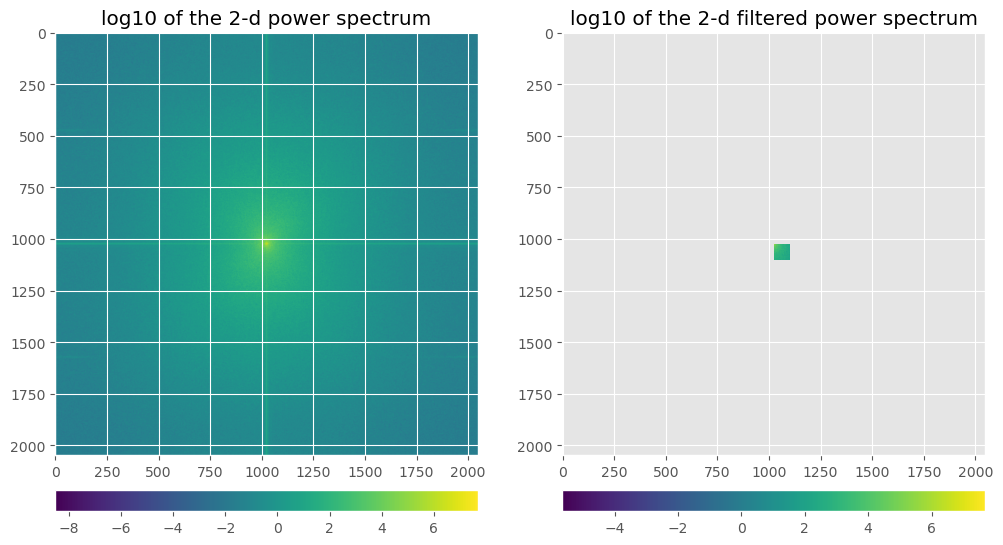

In [30]:
fig,[ax1, ax2]=plt.subplots(1,2,figsize=(12,7))
ax1.set_title('landsat a17')
im01=ax1.imshow(np.log10(output.spectral_dens))
ax1.set_title('log10 of the 2-d power spectrum')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im01,orientation='horizontal',cax=cax1)
#
ax2.set_title('landsat a17')
im02=ax2.imshow(np.log10(output.filtered_spec_dens))
ax2.set_title('log10 of the 2-d filtered power spectrum')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im02,orientation='horizontal',cax=cax2)

In [ ]:
avg_binwidth=5  #make the kradial bins 5 pixels wide
output.annular_avg(avg_binwidth)

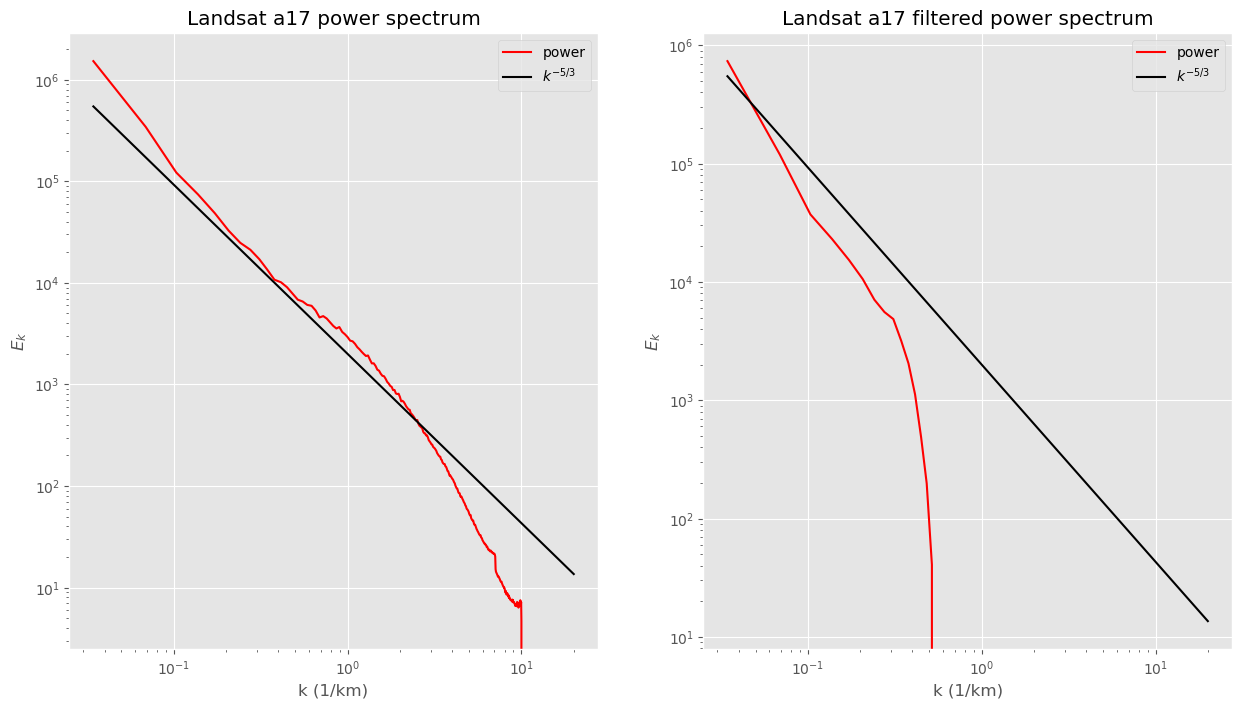

In [40]:
# output.graph_spectrum(kol_offset=2000.,title='Landsat {} power spectrum'.format(output.filename))
output.graph_spectrum(kol_offset=2000.)

No energy at wavenumers greater than 1 km^1